# Import Block

In [ ]:
import os
import tensorflow as tf
import gdown
import zipfile
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
!pip install gdown
!pip install rasterio
!pip install tensorflow

sub import

In [ ]:
from PIL import Image
from tensorflow.keras import layers, Model, Input
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Downloading the data

In [ ]:
folder_url = "https://drive.google.com/file/d/13Fx0DRAu5356ke765ZXUhfoJ-kLVc5LO/view?usp=sharing"
output = "satellite_data.zip"
gdown.download(folder_url, output, quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=13Fx0DRAu5356ke765ZXUhfoJ-kLVc5LO
From (redirected): https://drive.google.com/uc?id=13Fx0DRAu5356ke765ZXUhfoJ-kLVc5LO&confirm=t&uuid=9816f30d-e66d-4236-87e4-e90d9ae511a7
To: /content/satellite_data.zip
100%|██████████| 68.8M/68.8M [00:00<00:00, 74.2MB/s]


'satellite_data.zip'

unzip

In [ ]:
with zipfile.ZipFile(output) as zip_ref:
    zip_ref.extractall("satellite_data")

storing in directories

In [ ]:
data_directory = "satellite_data/satalite data/data"
images_directory = os.path.join(data_directory, "images")
labels_directory = os.path.join(data_directory, "labels")

checking directories

In [ ]:
print("Images directory:", images_directory)
print("Labels directory:", labels_directory)

Images directory: satellite_data/satalite data/data/images
Labels directory: satellite_data/satalite data/data/labels


# Data processing

In [ ]:
tif_files = [os.path.join(images_directory, f) for f in os.listdir(images_directory) if f.endswith(".tif")]
png_files = [os.path.join(labels_directory, f) for f in os.listdir(labels_directory) if f.endswith(".png")]

visible images preview

In [ ]:
print(f"found {len(tif_files)} images")
for tif_file in tif_files:
    with rasterio.open(tif_file) as source:
        # isolating rgb
        red = source.read(4).astype(np.float32)
        green = source.read(3).astype(np.float32)
        blue = source.read(2).astype(np.float32)
        rgb = np.stack([red,green,blue], axis=-1)
        #normalization
        rgb_min = np.min(rgb, axis=(0,1))
        rgb_max = np.max(rgb, axis=(0,1))
        rgb_normalized = (rgb - rgb_min) / (rgb_max - rgb_min + 0.000001)
        #show figure
        plt.figure(figsize=(6,6))
        plt.imshow(rgb_normalized)
        plt.title(os.path.basename(tif_file))
        plt.axis("off")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Preprocessing

In [ ]:
all_images = []
all_labels = []
selected_bands = [2, 3, 4, 5, 6, 7]
for tif_file, png_file in zip(tif_files, png_files):
    with rasterio.open(tif_file) as source:
        bands = []
        for b in selected_bands:
            band_data = source.read(b).astype(np.float32)
            #normalization
            band_min = np.min(band_data)
            band_max = np.max(band_data)
            band_norm = (band_data -band_min) / (band_max - band_min + 0.000001)
            bands.append(band_norm)
        #stacking bands
        image_array = np.stack(bands, axis=-1)
        all_images.append(image_array)
    # loading label mask
    mask = np.array(Image.open(png_file))
    if mask.ndim == 3:
        mask = mask[:,:,0]
    all_labels.append(mask)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


convert to arrays

In [ ]:
all_images = np.array(all_images)
all_labels = np.array(all_labels).astype(np.uint8)

compute water percentage

In [ ]:
def compute_patch_percentage(mask, patch_size=32):
    h, w = mask.shape
    new_h = (h // patch_size) * patch_size
    new_w = (w // patch_size) * patch_size
    mask = mask[:new_h, :new_w]  # crop to multiple of patch_size
    out_mask = np.zeros((new_h, new_w), dtype=np.uint8)
    for i in range(0, new_h, patch_size):
        for j in range(0, new_w, patch_size):
            patch = mask[i:i+patch_size, j:j+patch_size]
            pct = 100.0 * patch.sum() / patch.size
            cls = np.clip(int(pct // 10), 0, 9)
            out_mask[i:i+patch_size, j:j+patch_size] = cls
    return out_mask

application

In [ ]:
all_labels_binned = [compute_patch_percentage(m, patch_size=32) for m in all_labels]
all_labels_binned = np.array(all_labels_binned).astype(np.int32)

compute class weights

In [ ]:
flat_labels = all_labels_binned.flatten()
counts = np.bincount(flat_labels)
weights = 1.0 / (counts + 1e-6)
weights = weights / weights.sum() * len(weights)  # normalise
class_weights = weights.astype(np.float32)
weights = (1.0 / (counts + 1e-6))**1.5  # make rare classes much heavier

testing

In [ ]:
print(f"Processed {all_images.shape[0]} image-mask pairs.")
print("Image shape:", all_images.shape[1:])
print("Mask shape:", all_labels.shape[1:])
print("Class weights:", class_weights)
print("Images shape:", all_images.shape, "Binned labels shape:", all_labels_binned.shape)

Processed 306 image-mask pairs.
Image shape: (128, 128, 6)
Mask shape: (128, 128)
Class weights: [0.12179068 1.0980266  0.99998856 1.2121073  1.1914757  1.4583166
 1.2499857  1.1522502  1.1067066  0.40935203]
Images shape: (306, 128, 128, 6) Binned labels shape: (306, 128, 128)


# Different Approach

patches

In [ ]:
patch_size = 128  # patch size to train on
patches_X = []
patches_Y = []

for img, mask in zip(all_images, all_labels_binned):
    H, W = mask.shape
    # ensure we only take full patches
    for i in range(0, H - patch_size + 1, patch_size):
        for j in range(0, W - patch_size + 1, patch_size):
            p_img = img[i:i+patch_size, j:j+patch_size, :]
            p_mask = mask[i:i+patch_size, j:j+patch_size]
            patches_X.append(p_img)
            patches_Y.append(p_mask)

patches_X = np.array(patches_X, dtype=np.float32)
patches_Y = np.array(patches_Y, dtype=np.int32)

applying patches

In [ ]:
# group patches by dominant class (to oversample minority bins)
bin_groups = {i: [] for i in range(10)}
for x, y in zip(patches_X, patches_Y):
    dominant = np.bincount(y.flatten()).argmax()
    bin_groups[dominant].append((x, y))

# find target length (you can choose a smaller max to avoid huge memory)
max_len = max(len(g) for g in bin_groups.values() if len(g) > 0)

balanced_X = []
balanced_Y = []
for i in range(10):
    group = bin_groups[i]
    if len(group) == 0:
        continue
    # oversample by random choices until group length == max_len
    picks = list(group)
    while len(picks) < max_len:
        picks.extend(random.sample(group, min(len(group), max_len - len(picks))))
    for x, y in picks:
        balanced_X.append(x)
        balanced_Y.append(y)

balanced_X = np.array(balanced_X, dtype=np.float32)
balanced_Y = np.array(balanced_Y, dtype=np.int32)


extra

In [ ]:
flat = balanced_Y.flatten()
cw = compute_class_weight(class_weight="balanced", classes=np.arange(10), y=flat)
class_weights = np.array(cw, dtype=np.float32)
cw_tf = tf.constant(class_weights, dtype=tf.float32)  # used by weighted_focal_loss

test

In [ ]:
print("Patches total (balanced):", balanced_X.shape[0])
print("Patch shape:", balanced_X.shape[1:], "Patch mask shape:", balanced_Y.shape[1:])

Patches total (balanced): 2050
Patch shape: (128, 128, 6) Patch mask shape: (128, 128)


image augementatio

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20
)


extra

In [ ]:
# -----------------------
# TF dataset with augmentation (applies same ops to image & mask)
# -----------------------
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 8  # try 8 or 16 if you have memory

def augment_image_mask(image, mask):
    # augment image (already 3D)
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)

    # add a channel to mask before rotation
    mask = tf.expand_dims(mask, axis=-1)           # (H,W) → (H,W,1)
    mask = tf.image.rot90(mask, k)
    mask = tf.squeeze(mask, axis=-1)               # back to (H,W)

    # flips
    do_flip = tf.random.uniform([]) > 0.5
    image = tf.cond(do_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    mask  = tf.cond(do_flip, lambda: tf.image.flip_left_right(tf.expand_dims(mask,-1)), lambda: tf.expand_dims(mask,-1))
    mask  = tf.squeeze(mask, -1)

    return image, mask


def preprocess_dataset(images, masks, training=True):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    if training:
        ds = ds.shuffle(buffer_size=2048)
        ds = ds.map(lambda x,y: tf.py_function(func=augment_image_mask,
                                               inp=[x,y],
                                               Tout=(tf.float32, tf.int32)),
                    num_parallel_calls=AUTOTUNE)
        # after tf.py_function, shape info is lost; restore shapes:
        ds = ds.map(lambda x,y: (tf.reshape(x, (patch_size, patch_size, images.shape[-1])),
                                tf.reshape(y, (patch_size, patch_size))),
                    num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), tf.cast(y, tf.int32)),
                    num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = preprocess_dataset(balanced_X, balanced_Y, training=True)
# Optionally create a small validation split from balanced dataset:
val_split = int(0.1 * balanced_X.shape[0])
val_ds = preprocess_dataset(balanced_X[:val_split], balanced_Y[:val_split], training=False)
train_ds = preprocess_dataset(balanced_X[val_split:], balanced_Y[val_split:], training=True)


extra

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(
    balanced_X, balanced_Y, test_size=0.2, random_state=42
)
# training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
train_ds = train_ds.shuffle(1000).map(lambda x, y: augment_image_mask(x, y),
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(16).prefetch(tf.data.AUTOTUNE)

# validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_Y))
val_ds = val_ds.batch(16).prefetch(tf.data.AUTOTUNE)

# Building the model

loss function

In [ ]:
def weighted_focal_loss(y_true, y_pred, gamma=3.0):
    # make sure y_true is int32
    y_true = tf.cast(y_true, tf.int32)

    # cast your precomputed class weights to float32
    weights = tf.gather(tf.cast(cw, tf.float32), y_true)

    # cross entropy
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # probability of the true class
    pt = tf.reduce_sum(
        y_pred * tf.one_hot(y_true, depth=10, dtype=tf.float32), axis=-1
    )

    # focal loss part
    fl = weights * ((1.0 - pt) ** gamma) * ce

    return tf.reduce_mean(fl)
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(10),
    y=flat_labels
).astype(np.float32)  # <--- important



model

In [ ]:
def unet_model_multiclass(input_size=(128, 128, 6), num_classes=10):
    inputs = Input(input_size)
    # encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

prepping the model

In [ ]:
water_classifier = unet_model_multiclass(input_size=(patch_size, patch_size, all_images.shape[-1]), num_classes=10)
water_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=lambda y_true, y_pred: weighted_focal_loss(y_true, y_pred, gamma=3.0),
    metrics=["accuracy"]
)


preview

In [ ]:
water_classifier.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 128, 128,  │      3,520 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_190[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_40    │ (None, 64, 64,    │          0 │ conv2d_191[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_40… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_192[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_41    │ (None, 32, 32,    │          0 │ conv2d_193[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_194 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_41… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_194[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 16, 16,    │          0 │ conv2d_195[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_42… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_196[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 8, 8, 512) │          0 │ conv2d_197[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_43… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_199 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_198[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_40 │ (None, 16, 16,    │  2,097,664 │ conv2d_199[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_40      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,034,058 (118.39 MB)

 Trainable params: 31,034,058 (118.39 MB)

 Non-trainable params: 0 (0.00 B)

checkpoint

In [ ]:
os.makedirs("checkpoints", exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath="checkpoints/best_model.keras",  # file to save
    monitor="val_loss",                   # metric to watch
    save_best_only=True,                  # only keep best
    save_weights_only=False,              # save full model
    mode="min",                           # 'min' for loss, 'max' for acc
    verbose=1
)

# Training the model

In [ ]:
history = water_classifier.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[checkpoint]
)


Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8015 - loss: 0.2768
Epoch 1: val_loss improved from 0.34762 to 0.33973, saving model to checkpoints/best_model.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: weighted_focal_loss(y_true, y_pred, gamma=3.0),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


103/103 ━━━━━━━━━━━━━━━━━━━━ 51s 495ms/step - accuracy: 0.8016 - loss: 0.2766 - val_accuracy: 0.7807 - val_loss: 0.3397
Epoch 2/100


# Data visulaization

In [ ]:
predictions = water_classifier.predict(all_images)
predicted_classes = np.argmax(predictions, axis=-1)
y_true = all_labels_binned.flatten()
y_pred = predicted_classes.flatten()

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step


confusion matrix

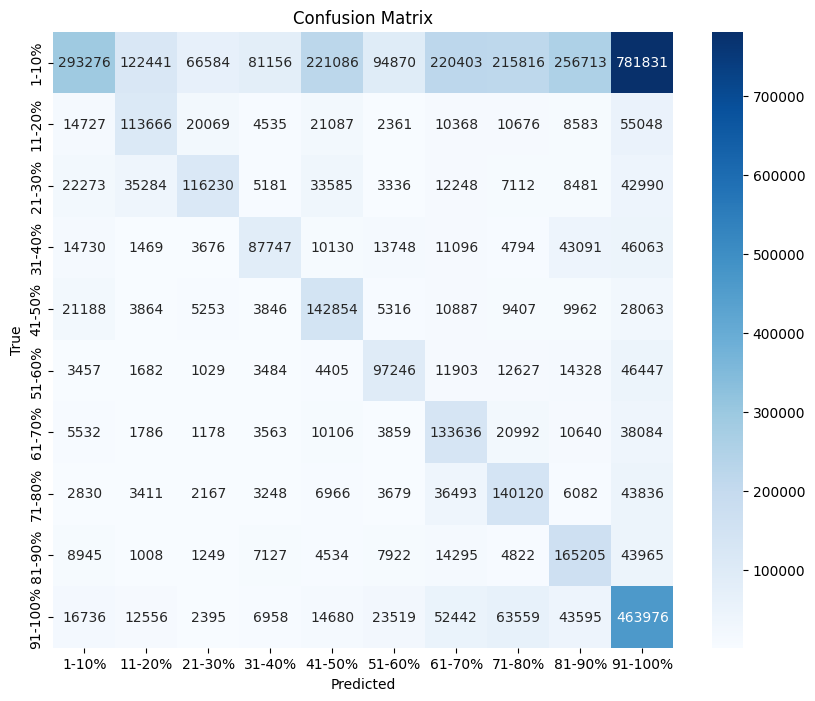

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels=np.arange(10))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i*10+1}-{(i+1)*10}%" for i in range(10)],
            yticklabels=[f"{i*10+1}-{(i+1)*10}%" for i in range(10)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

classification report

In [ ]:
print(classification_report(y_true, y_pred, labels=np.arange(10)))

              precision    recall  f1-score   support

           0       0.73      0.12      0.21   2354176
           1       0.38      0.44      0.41    261120
           2       0.53      0.41      0.46    286720
           3       0.42      0.37      0.40    236544
           4       0.30      0.59      0.40    240640
           5       0.38      0.49      0.43    196608
           6       0.26      0.58      0.36    229376
           7       0.29      0.56      0.38    248832
           8       0.29      0.64      0.40    259072
           9       0.29      0.66      0.41    700416

    accuracy                           0.35   5013504
   macro avg       0.39      0.49      0.39   5013504
weighted avg       0.52      0.35      0.31   5013504



mean IoU

In [ ]:
def mean_iou(y_true, y_pred, num_classes=10):
    ious = []
    for i in range(num_classes):
        intersection = np.logical_and(y_true == i, y_pred == i).sum()
        union = np.logical_or(y_true == i, y_pred == i).sum()
        if union == 0:
            ious.append(np.nan)
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)
print("Mean IoU:", mean_iou(y_true, y_pred, num_classes=10))

Mean IoU: 0.24021768530901327


test

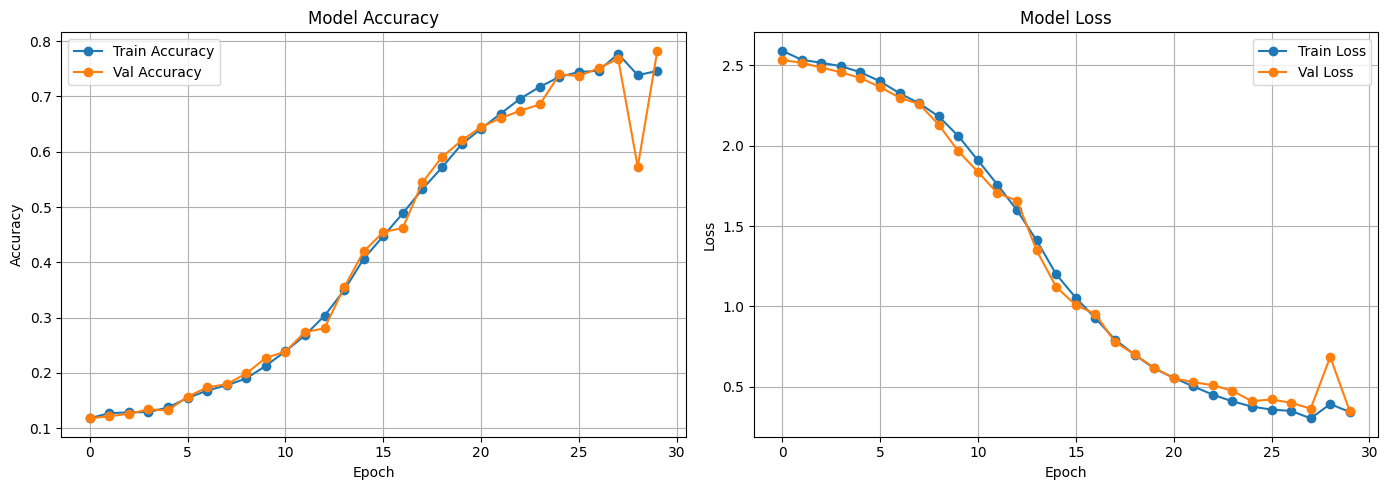

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
plt.plot(history.history['mean_io_u'], label='Train IoU')
plt.plot(history.history['val_mean_io_u'], label='Val IoU')
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'plt' is not defined